In [1]:
import pickle
from functools import partial

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import optax
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm
from sbi_lens.config import config_lsst_y_10

tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
total_steps = 5_000_000
sbi_method = 'nle'
batch_size = 256
params_name = config_lsst_y_10.params_name_latex

In [3]:
if sbi_method == "npe":
    dataset = np.load(
            "gpfswork/rech/eqw/ufa23yn/ssnpe_desc_project/data/LOADED&COMPRESSED_year_10_with_noise_score_density.npz",
            allow_pickle=True,
        )["arr_0"]

elif sbi_method == "nle":
    dataset = np.load(
            "./LOADED&COMPRESSED_year_10_with_noise_score_conditional_very_large.npz",
            allow_pickle=True,
        )["arr_0"]


inds = jnp.unique(jnp.where(jnp.isnan(dataset.item()["score"]))[0])
dataset_y = jnp.delete(dataset.item()["y"], inds, axis=0)
dataset_score = jnp.delete(dataset.item()["score"], inds, axis=0)
dataset_theta = jnp.delete(dataset.item()["theta"], inds, axis=0)
# dataset_y = dataset_y[:90_000]
# dataset_theta = dataset_theta[:90_000]
# dataset_score = dataset_score[:90_000]

dataset_y_train = dataset_y[:len(dataset_score) - 2000]
dataset_score_train = dataset_score[:len(dataset_score) - 2000]
dataset_theta_train = dataset_theta[:len(dataset_score) - 2000]

dataset_y_test = dataset_y[len(dataset_score) - 2000:]
dataset_score_test = dataset_score[len(dataset_score) - 2000:]
dataset_theta_test = dataset_theta[len(dataset_score) - 2000:]

In [16]:
len(dataset_y_train)

450589

In [4]:
class MomentNetwork(hk.Module):
 
  def __call__(self, theta, y):
        
    net = jnp.concatenate([theta, y], axis = -1)
    net = hk.Linear(128)(net)
    net = jax.nn.relu(net)
    net = hk.Linear(256)(net)
    net = jax.nn.relu(net)
    net = hk.Linear(256)(net)
    net = jax.nn.relu(net)
    net = hk.Linear(256)(net)
    net = jax.nn.relu(net)
    net = hk.Linear(256)(net)
    net = jax.nn.relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.relu(net)
    net = hk.Linear(6)(net)

    return net.squeeze()

In [5]:
get_moments = hk.without_apply_rng(hk.transform(lambda theta, y : MomentNetwork()(theta, y)))

# Predict esperance

In [6]:
@jax.jit
def loss_esperance(params, theta, y, score):

  out = get_moments.apply(params, theta, y)

  return jnp.sum((out - score) ** 2, axis=-1).mean() / 1000

@jax.jit
def update_esperance(params, opt_state, theta, y, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_esperance)(
        params, theta, y, score
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

In [7]:
rng_seq = hk.PRNGSequence(12)
params_esperance = get_moments.init(next(rng_seq), jnp.zeros([1, 6]), jnp.zeros([1, 6]))

nb_steps = total_steps - total_steps * 0.3

lr_scheduler = optax.exponential_decay(
        init_value=0.001,
        transition_steps=nb_steps // 60,
        decay_rate=0.9,
        end_value=1e-6,
    )

optimizer = optax.adam(lr_scheduler)
opt_state_esperance = optimizer.init(params_esperance)

batch_loss = []
val_loss = []
lr_scheduler_store = []
pbar = tqdm(range(total_steps + 1))

for batch in pbar:
    inds = np.random.randint(0, len(dataset_score_train), batch_size)
    inds2 = np.random.randint(0, len(dataset_score_test), batch_size)
    ex_score = dataset_score_train[inds]
    ex_theta = dataset_theta_train[inds]
    ex_y = dataset_y_train[inds]

    l, params_esperance, opt_state_esperance = update_esperance(
        params_esperance, opt_state_esperance, ex_theta, ex_y, ex_score
    )

    if batch % 500 == 0:
      batch_loss.append(l)
      val_loss.append(
          loss_esperance(
              params_esperance, 
              dataset_theta_test[inds2], 
              dataset_y_test[inds2],
              dataset_score_test[inds2]
          )
      )
      lr_scheduler_store.append(lr_scheduler(batch))
      pbar.set_description(f"train loss {l:.3f}")

    if jnp.isnan(l):
        break

train loss 312.115: 100%|██████████| 5000001/5000001 [1:02:03<00:00, 1342.71it/s]


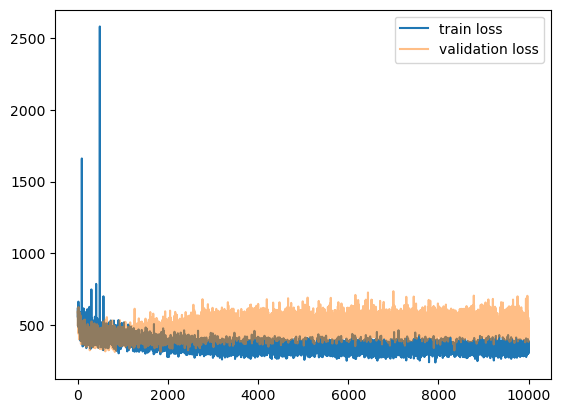

In [8]:
plt.plot(batch_loss, label = 'train loss')
plt.plot(val_loss, alpha = 0.5, label = 'validation loss')
plt.legend()
plt.savefig( "./SNR_study/loss.png")

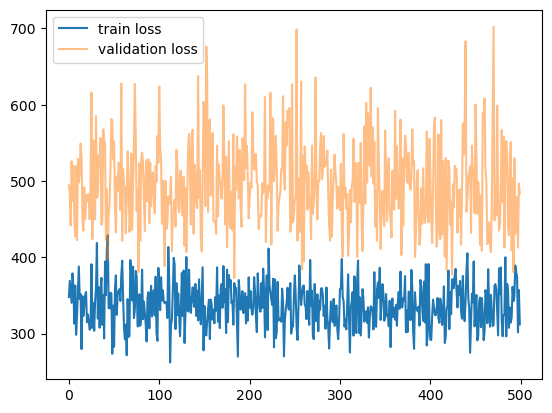

In [9]:
plt.plot(batch_loss[-500:], label = 'train loss')
plt.plot(val_loss[-500:], alpha = 0.5, label = 'validation loss')
plt.legend()
plt.savefig( "./SNR_study/loss_zoom.png")

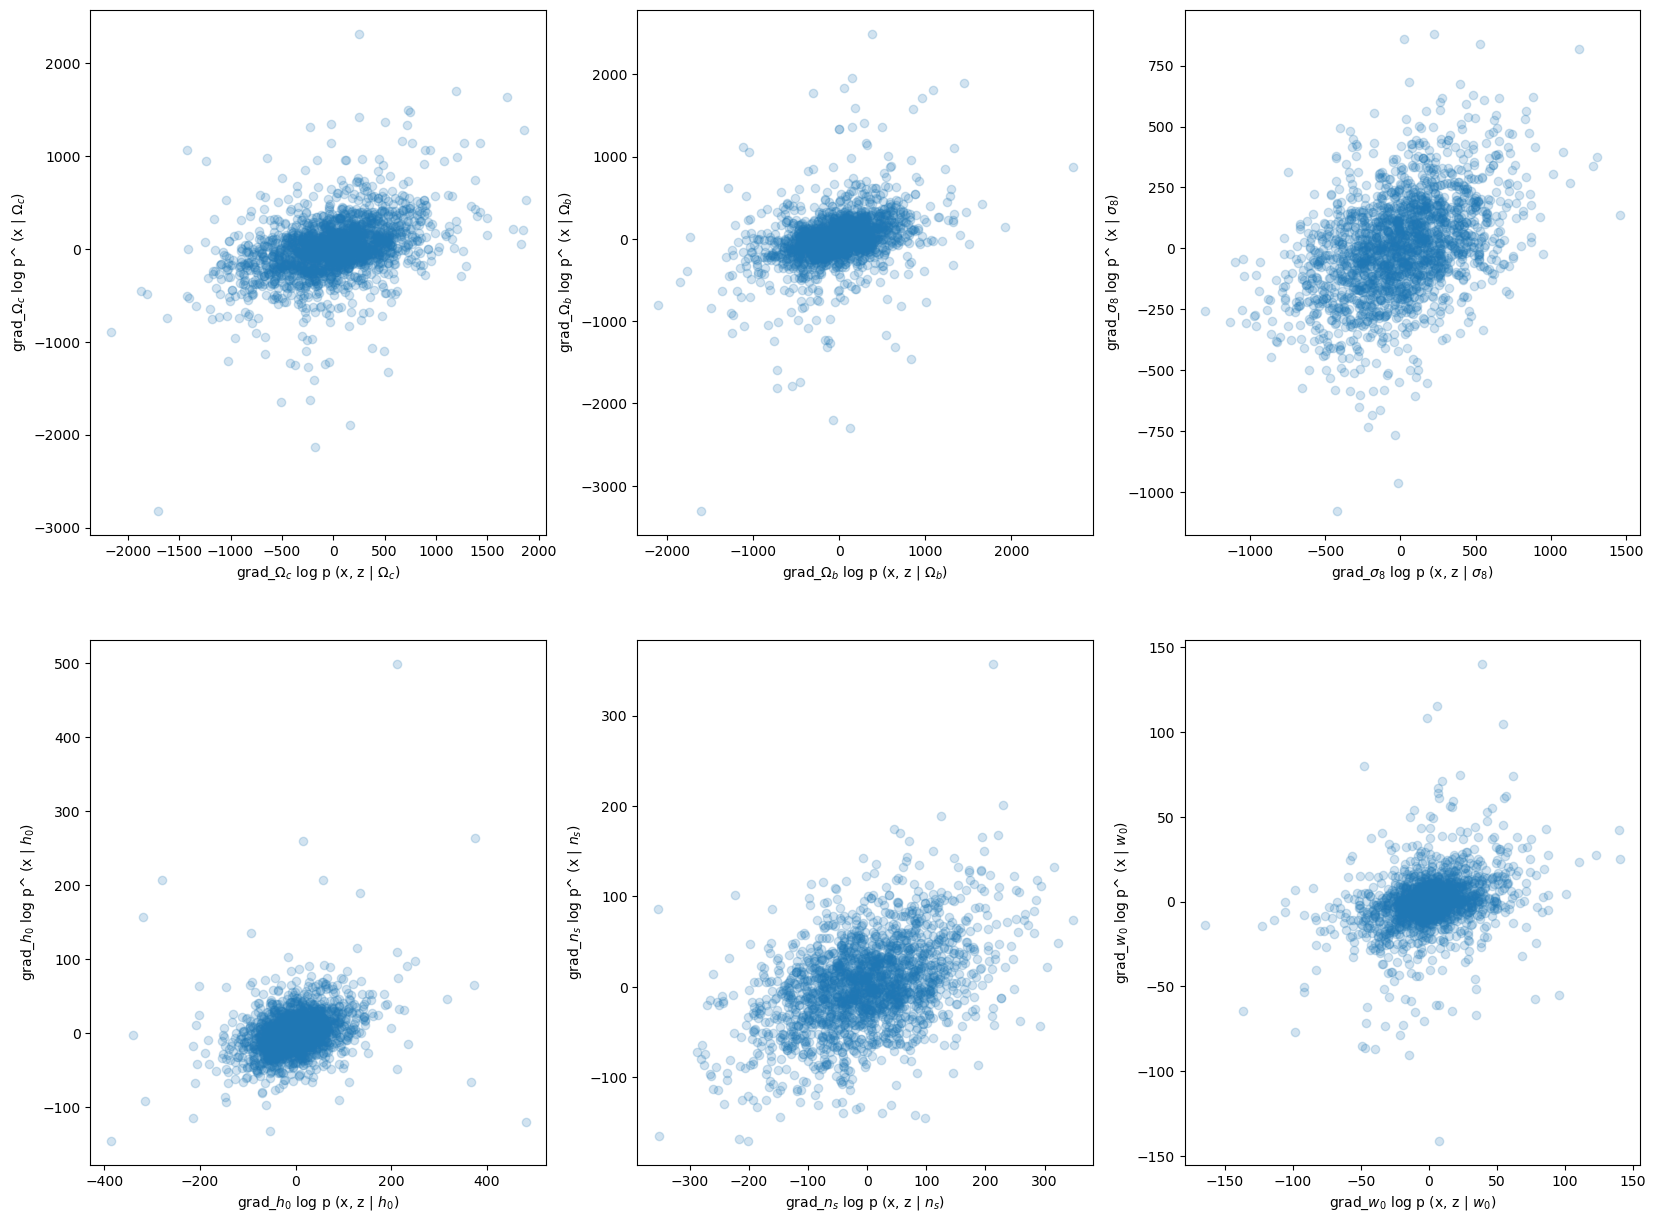

In [10]:
# check regression on test set

prediction = get_moments.apply(
    params_esperance,  
    dataset_theta_test,
    dataset_y_test
)

plt.figure(figsize=(20, 15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(dataset_score_test[...,i], prediction[...,i], alpha = 0.2)
  plt.ylabel('grad_{} log p^ (x | {})'.format(params_name[i], params_name[i]))
  plt.xlabel('grad_{} log p (x, z | {})'.format(params_name[i], params_name[i]))
    
plt.savefig( "./SNR_study/regression.png")

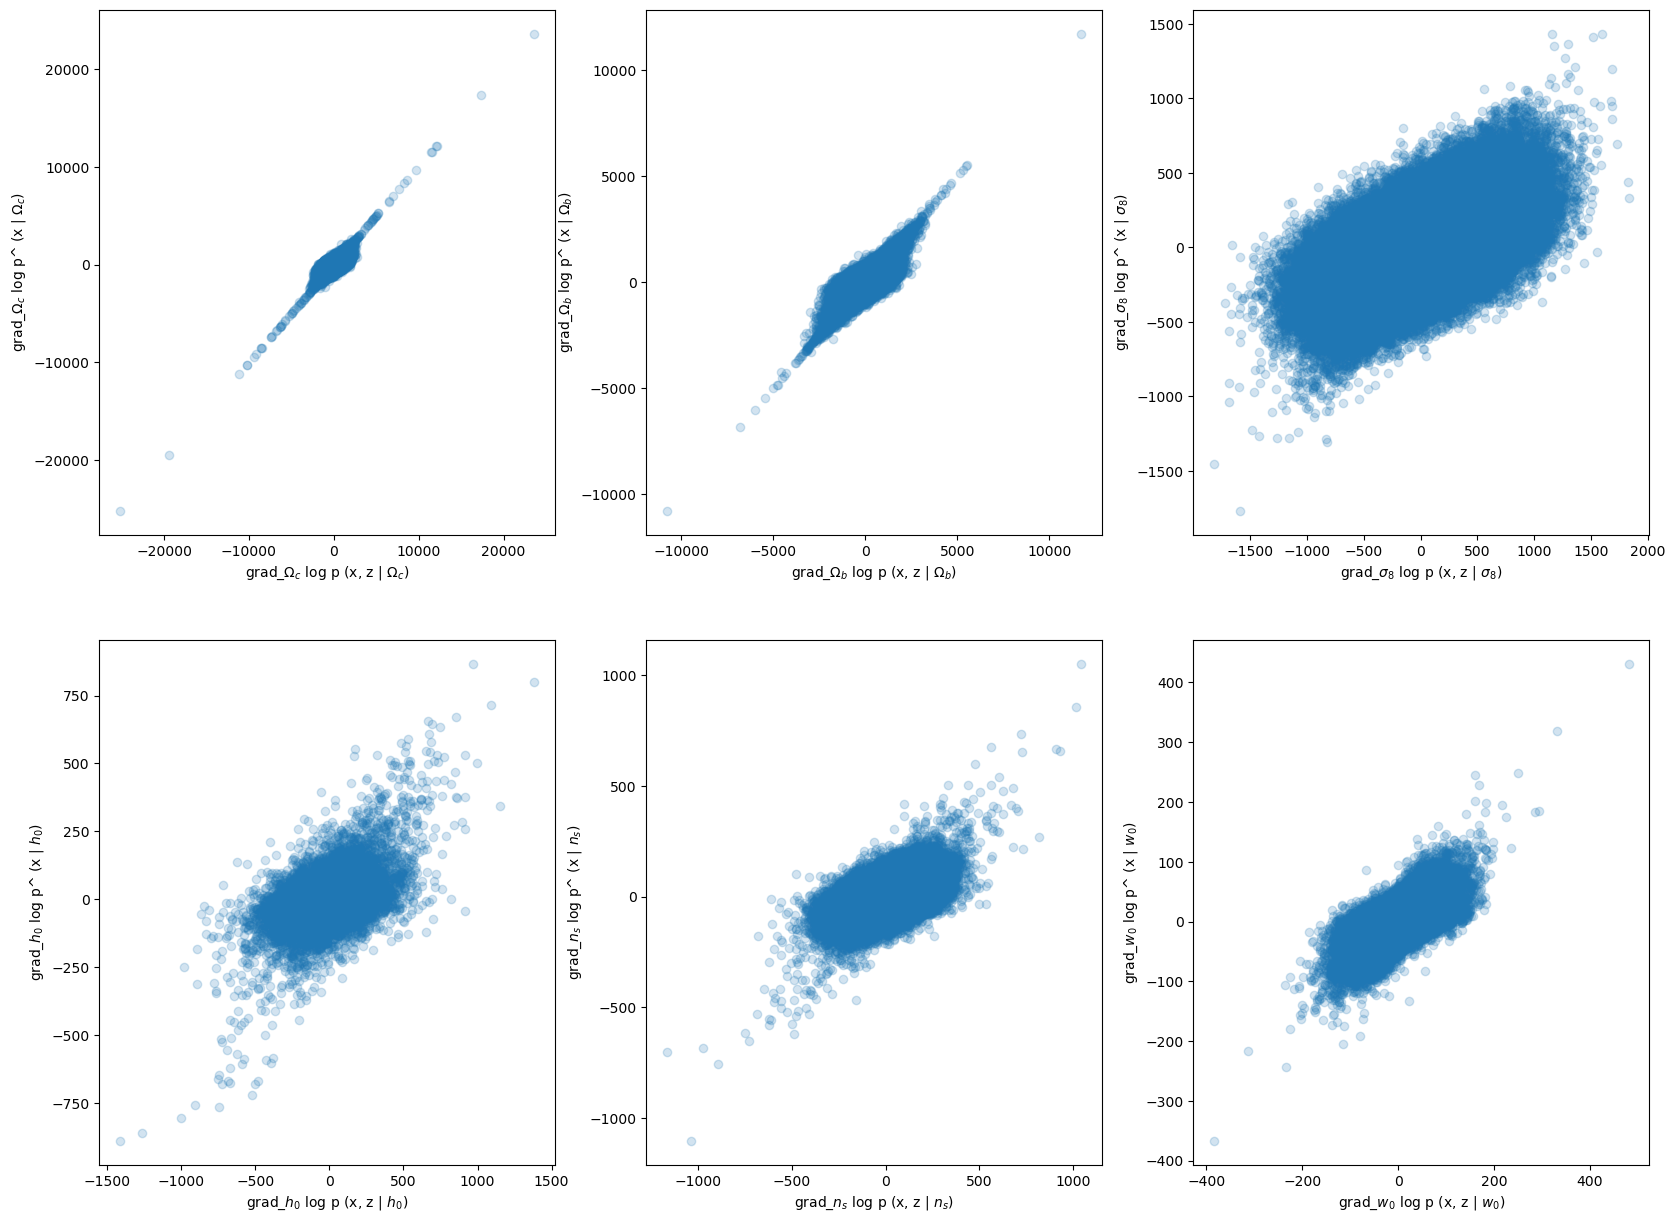

In [11]:
# check regression on train set

prediction = get_moments.apply(
    params_esperance,  
    dataset_theta_train,
    dataset_y_train
)

plt.figure(figsize=(20, 15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(dataset_score_train[...,i], prediction[...,i], alpha = 0.2)
  plt.ylabel('grad_{} log p^ (x | {})'.format(params_name[i], params_name[i]))
  plt.xlabel('grad_{} log p (x, z | {})'.format(params_name[i], params_name[i]))
    
plt.savefig( "./SNR_study/regression.png")

In [12]:
with open(
   "./SNR_study/params_esp.pkl", "wb"
) as fp:
    pickle.dump(params_esperance, fp)

# Predict std

In [13]:
@jax.jit
def loss_std(params,  theta, y, score):

    approx_esp = get_moments.apply(params_esperance, theta, y)
    approx_std = get_moments.apply(params, theta, y)
    approx_var = approx_std ** 2
    var = (approx_esp - score) ** 2

    return jnp.sum((var - approx_var) ** 2, axis=-1).mean() 


@jax.jit
def update_std(params, opt_state, theta, y, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_std)(
        params, theta, y, score
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

In [14]:
rng_seq = hk.PRNGSequence(10)
params_std = get_moments.init(next(rng_seq), jnp.zeros([1, 6]), jnp.zeros([1, 6]))

nb_steps = total_steps  - total_steps * 0.3

lr_scheduler = optax.exponential_decay(
        init_value=0.001,
        transition_steps=nb_steps // 60,
        decay_rate=0.9,
        end_value=1e-6,
    )

optimizer = optax.adam(lr_scheduler)
opt_state_std = optimizer.init(params_std)

batch_loss_std = []
val_loss_std = []
lr_scheduler_store = []
pbar = tqdm(range(total_steps + 1))

for batch in pbar:
    inds = np.random.randint(0, len(dataset_score_train), batch_size)
    inds2 = np.random.randint(0, len(dataset_score_test) - 1, batch_size)
    ex_score = dataset_score_train[inds]
    ex_theta = dataset_theta_train[inds]
    ex_y = dataset_y_train[inds]

    l, params_std, opt_state_std = update_std(
        params_std, opt_state_std, ex_theta, ex_y, ex_score
    )

    if batch % 500 == 0:
      batch_loss_std.append(l)
      val_loss_std.append(
          loss_std(
              params_std, 
              dataset_theta_test[inds2], 
              dataset_y_test[inds2],
              dataset_score_test[inds2]
          )
      )
      lr_scheduler_store.append(lr_scheduler(batch))
      pbar.set_description(f"train loss {l:.3f}")

    if jnp.isnan(l):
        break

train loss 38855032832.000: 100%|██████████| 5000001/5000001 [1:09:28<00:00, 1199.59it/s] 


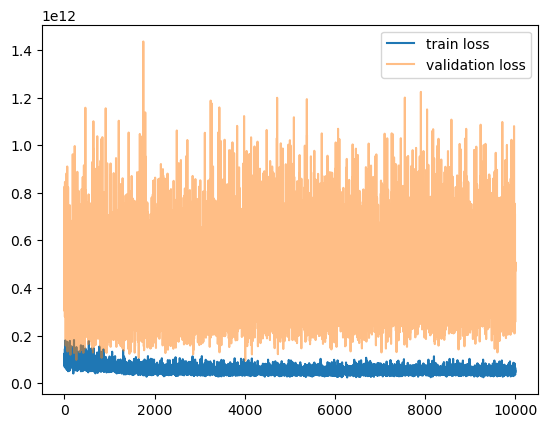

In [15]:
plt.plot(batch_loss_std, label = 'train loss')
plt.plot(val_loss_std, alpha = 0.5, label = 'validation loss')
plt.legend()
plt.savefig( "./SNR_study/loss_std.png")

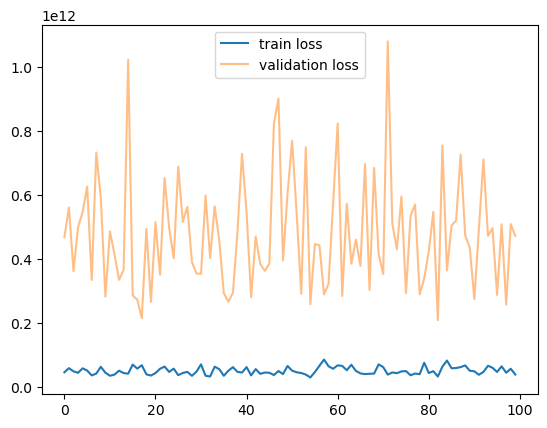

In [16]:
plt.plot(batch_loss_std[-100:], label = 'train loss')
plt.plot(val_loss_std[-100:], alpha = 0.5, label = 'validation loss')
plt.legend()
plt.savefig( "./SNR_study/loss_std_zoom.png")

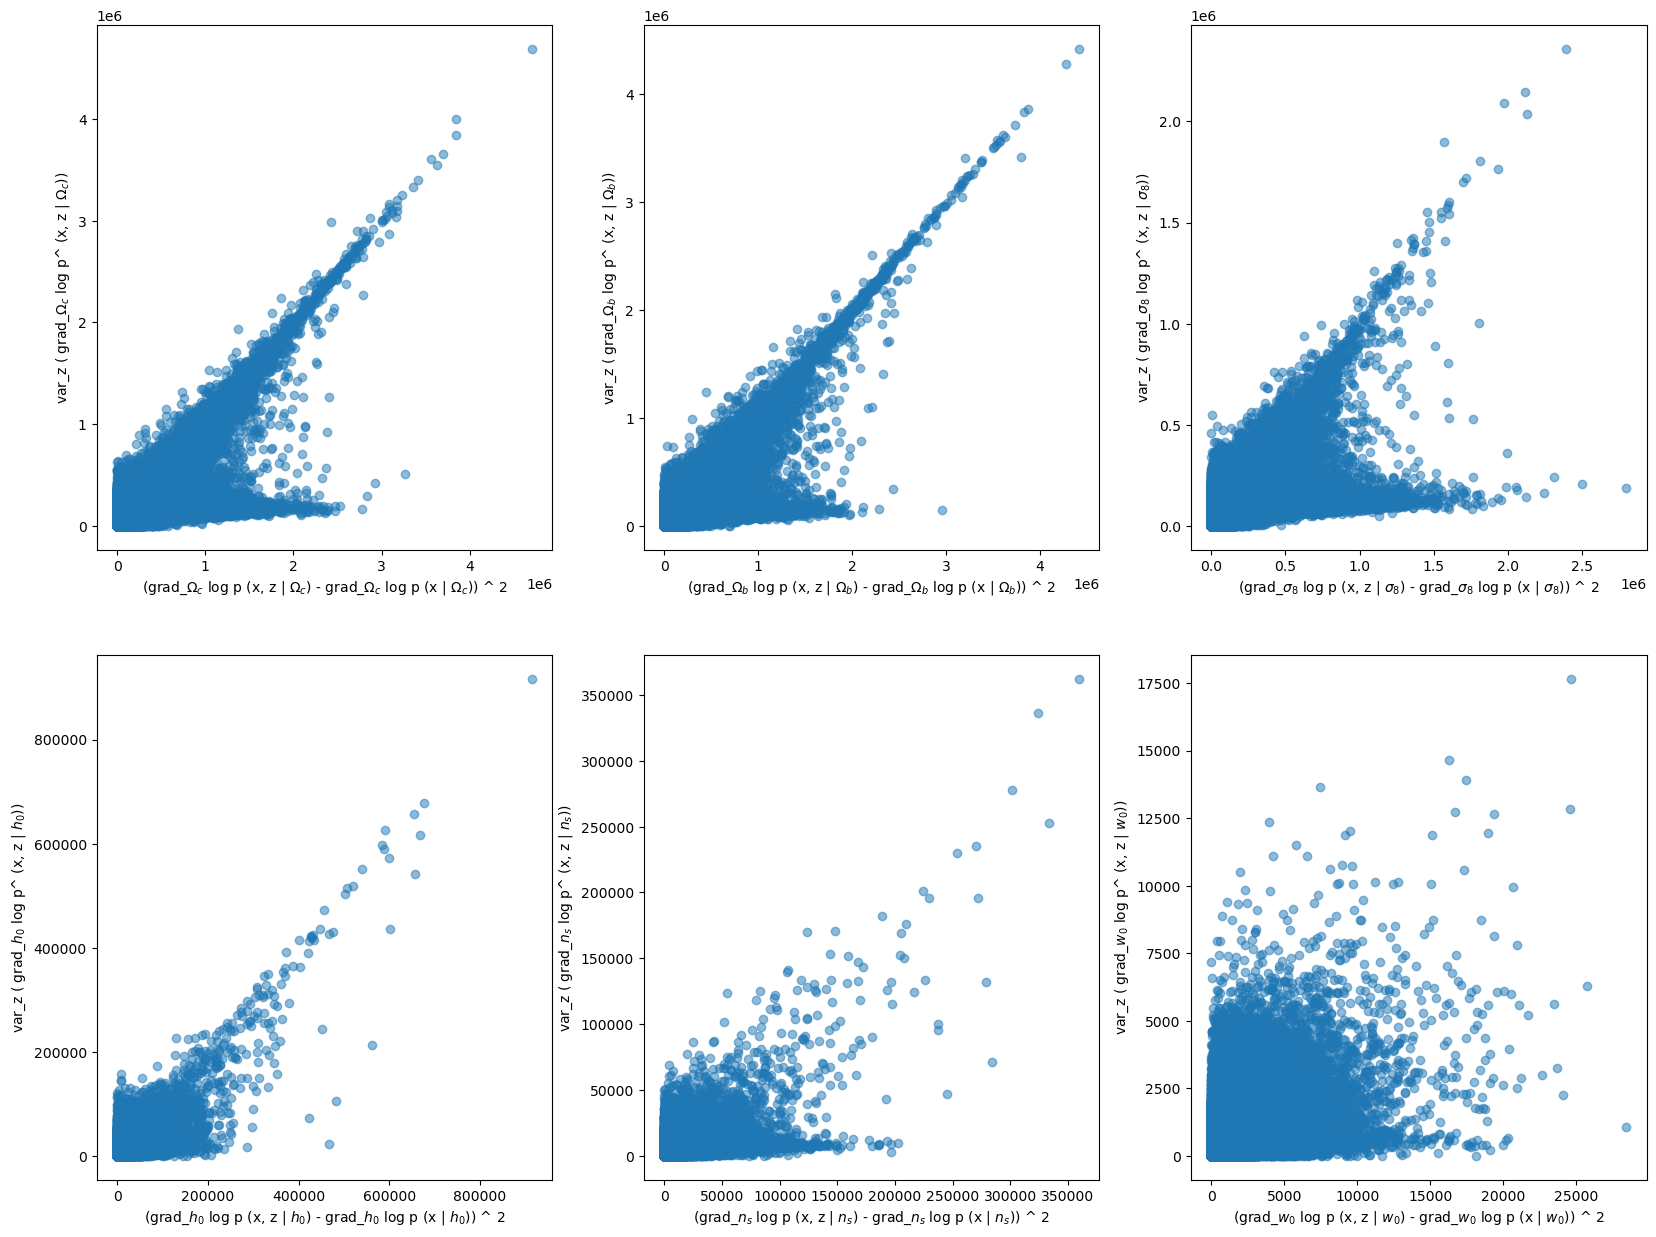

In [17]:
approx_esp = get_moments.apply(params_esperance, dataset_theta_train, dataset_y_train)

var = (approx_esp - dataset_score_train) ** 2

approx_std = get_moments.apply(params_std,  dataset_theta_train, dataset_y_train)
prediction = approx_std ** 2

plt.figure(figsize=(20,15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(var[...,i], prediction[...,i], alpha = 0.5)
  plt.ylabel('var_z ( grad_{} log p^ (x, z | {}))'.format(params_name[i], params_name[i]))
  plt.xlabel('(grad_{} log p (x, z | {}) - grad_{} log p (x | {})) ^ 2'.format(params_name[i], params_name[i], params_name[i], params_name[i]))
    
plt.savefig( "./SNR_study/regression_std_train.png")

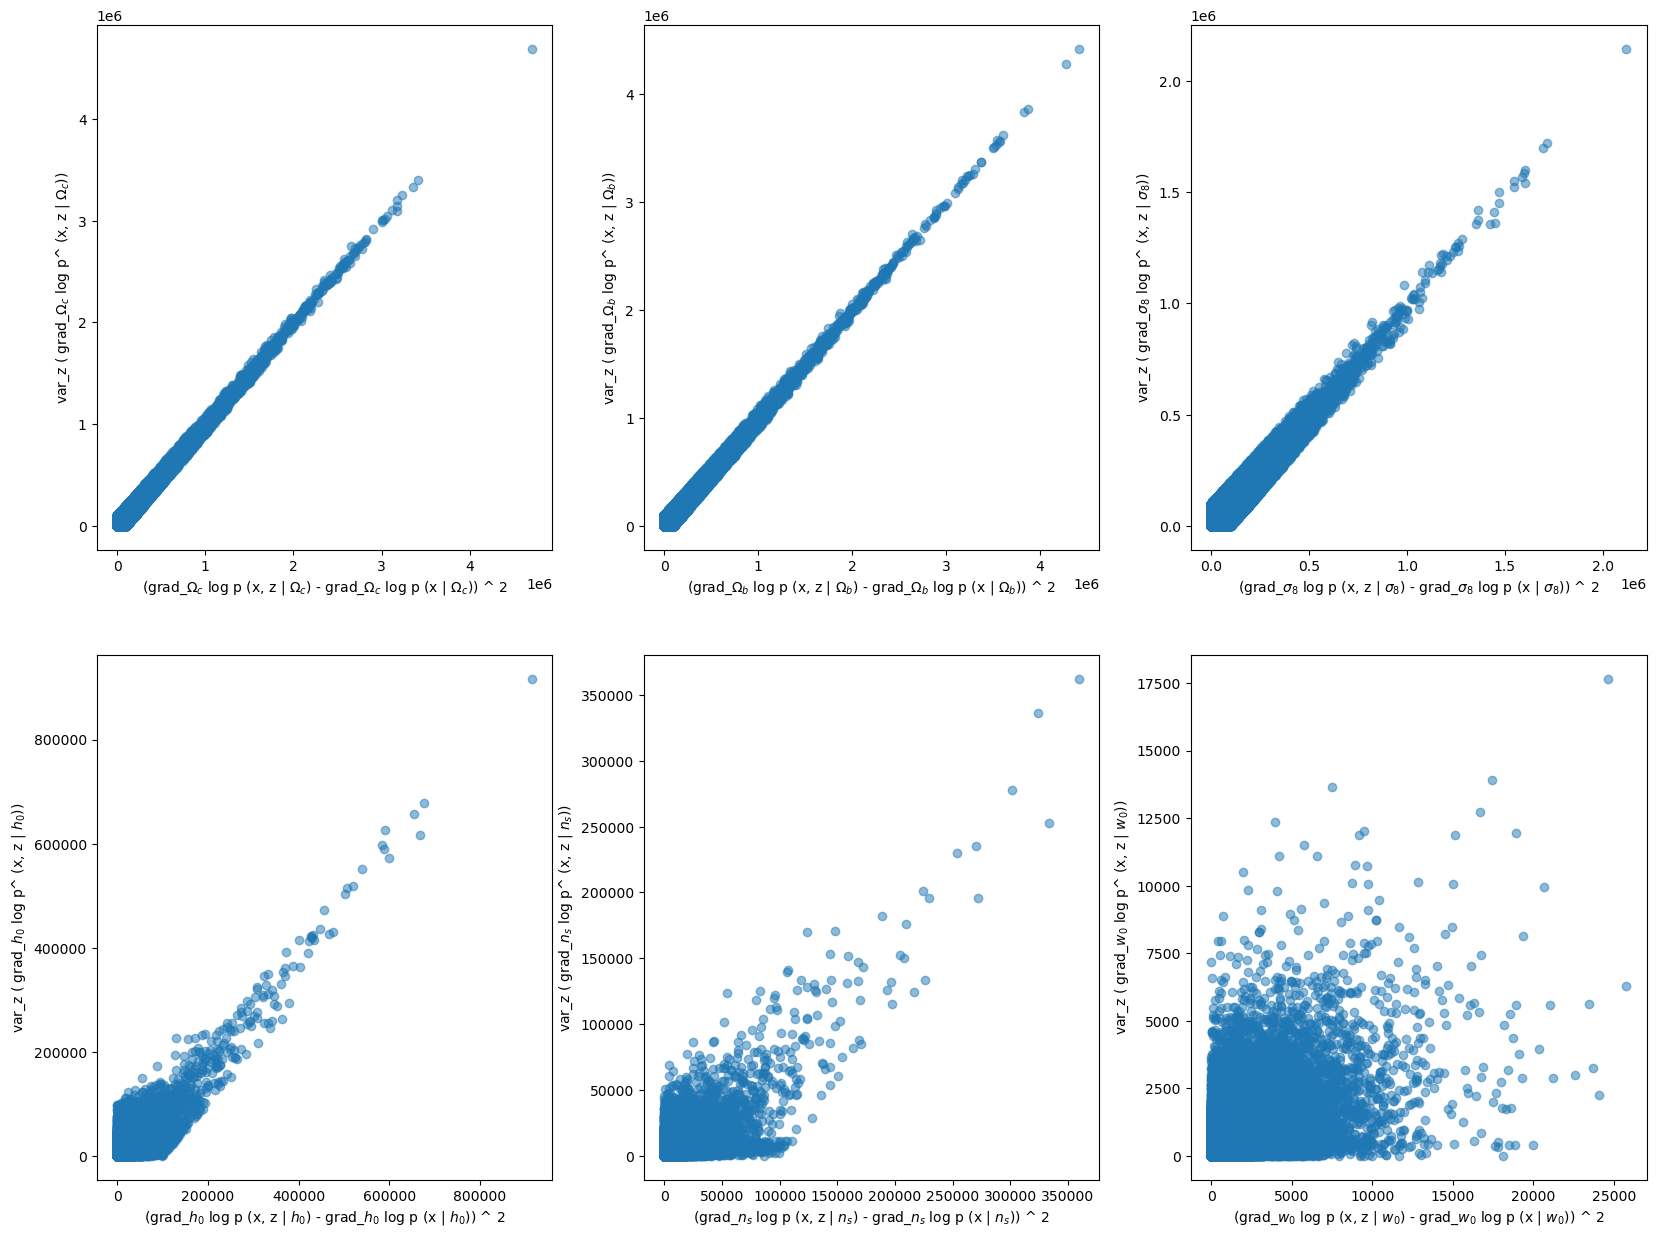

In [18]:
approx_esp = get_moments.apply(params_esperance, dataset_theta_train, dataset_y_train)

var = (approx_esp - dataset_score_train) ** 2

approx_std = get_moments.apply(params_std,  dataset_theta_train, dataset_y_train)
prediction = approx_std ** 2

inds = jnp.unique(jnp.where(jnp.abs(prediction - var) > 1e5)[0])

var_2 = jnp.delete(var, inds, axis = 0)
pred_2 = jnp.delete(prediction, inds, axis = 0)
    
plt.figure(figsize=(20,15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(var_2[...,i], pred_2[...,i], alpha = 0.5)
  plt.ylabel('var_z ( grad_{} log p^ (x, z | {}))'.format(params_name[i], params_name[i]))
  plt.xlabel('(grad_{} log p (x, z | {}) - grad_{} log p (x | {})) ^ 2'.format(params_name[i], params_name[i], params_name[i], params_name[i]))

plt.savefig( "./SNR_study/regression_std_train_zoom.png")

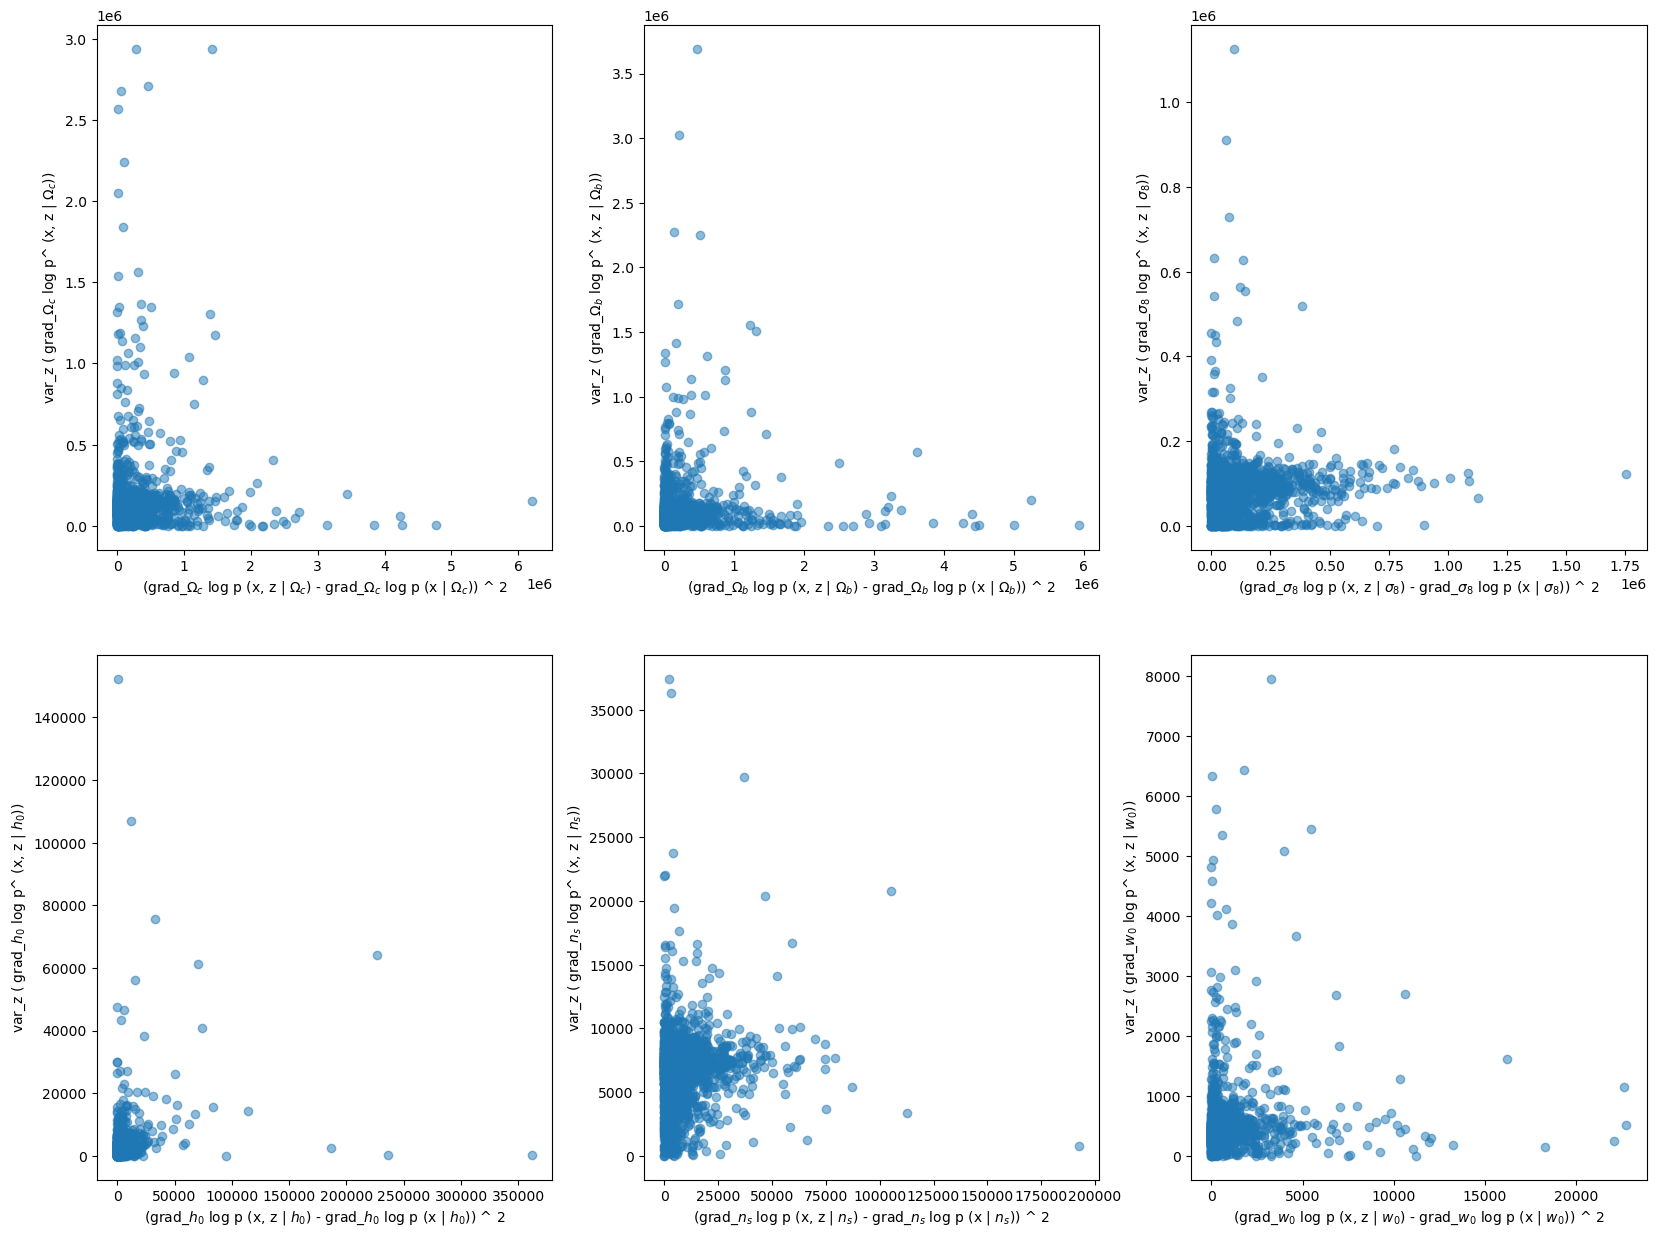

In [19]:
approx_esp = get_moments.apply(params_esperance, dataset_theta_test, dataset_y_test)

var = (approx_esp - dataset_score_test) ** 2

approx_std = get_moments.apply(params_std,  dataset_theta_test, dataset_y_test)
prediction = approx_std ** 2

plt.figure(figsize=(20,15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(var[...,i], prediction[...,i], alpha = 0.5)
  plt.ylabel('var_z ( grad_{} log p^ (x, z | {}))'.format(params_name[i], params_name[i]))
  plt.xlabel('(grad_{} log p (x, z | {}) - grad_{} log p (x | {})) ^ 2'.format(params_name[i], params_name[i], params_name[i], params_name[i]))
    
plt.savefig( "./SNR_study/regression_std_test.png")

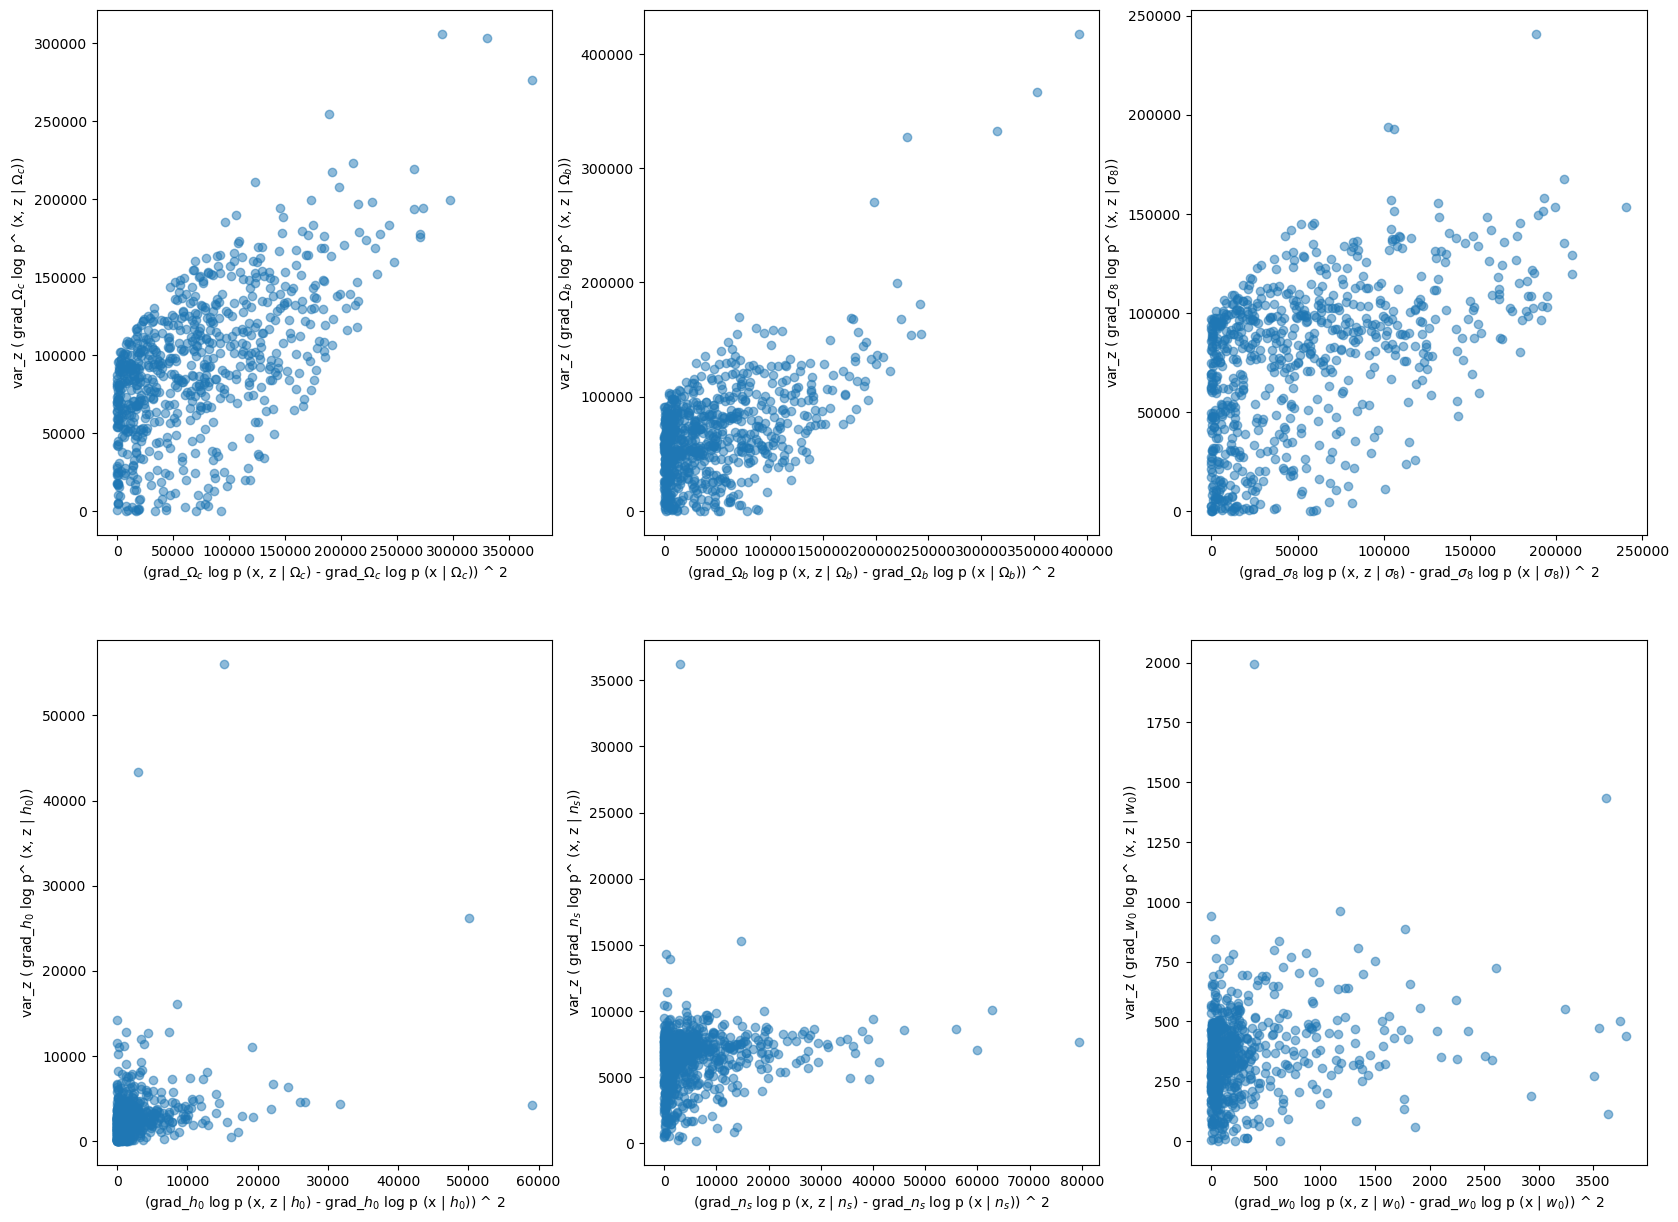

In [20]:
approx_esp = get_moments.apply(params_esperance, dataset_theta_test, dataset_y_test)

var = (approx_esp - dataset_score_test) ** 2

approx_std = get_moments.apply(params_std,  dataset_theta_test, dataset_y_test)
prediction = approx_std ** 2

inds = jnp.unique(jnp.where(jnp.abs(prediction - var) > 1e5)[0])

var_2 = jnp.delete(var, inds, axis = 0)
pred_2 = jnp.delete(prediction, inds, axis = 0)
    
plt.figure(figsize=(20,15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(var_2[...,i], pred_2[...,i], alpha = 0.5)
  plt.ylabel('var_z ( grad_{} log p^ (x, z | {}))'.format(params_name[i], params_name[i]))
  plt.xlabel('(grad_{} log p (x, z | {}) - grad_{} log p (x | {})) ^ 2'.format(params_name[i], params_name[i], params_name[i], params_name[i]))

plt.savefig( "./SNR_study/regression_std_test_zoom.png")

In [21]:
with open(
   "./SNR_study/params_std.pkl", "wb"
) as fp:
    pickle.dump(params_std, fp)

# Compute SNR

In [22]:
def get_SNR(theta, x):
  esperance = get_moments.apply(params_esperance, theta, x)
  std = get_moments.apply(params_std, theta, x)
  return esperance / std ** 2

In [23]:
get_SNR(dataset_theta[-10:], dataset_y[-10:])

Array([[-2.0736211e-03, -2.5715313e-03, -2.3166169e-03, -1.4965434e-02,
        -7.2500356e-03,  3.0564578e-02],
       [ 1.6070221e-04,  7.9585385e-04, -2.6556739e-04, -5.9958422e-03,
        -3.6404610e-03, -3.9904113e-03],
       [ 3.0657410e-04,  2.4144791e-04,  6.5948220e-04,  1.9215072e-03,
         2.9547428e-04,  1.9204989e-03],
       [-2.6954669e-03, -4.4178911e-03, -1.3963563e-03, -4.8602582e-03,
        -6.8844492e-03,  8.9558000e-03],
       [ 5.3962797e-04,  2.5898102e-04,  4.6949284e-05,  4.6970067e-03,
         4.6198205e-03,  1.3375639e-03],
       [ 1.0709510e-04,  7.6713518e-04,  5.9487741e-04, -1.6837606e-02,
        -4.7699274e-03, -1.3727808e-02],
       [-7.6813466e-04, -1.0338208e-03, -1.2165655e-03,  3.6924309e-03,
         2.9836479e-04,  9.9096168e-03],
       [ 4.3414631e-03,  4.3082717e-03,  2.8617508e-03,  2.5088245e-03,
         5.3598923e-03, -3.5922159e-02],
       [-1.1901025e-03, -1.7334205e-03, -1.7906275e-03, -1.1535045e-02,
        -4.5107151e-03, 

In [24]:
esperance = get_moments.apply(params_esperance, dataset_theta[-10:], dataset_y[-10:])
std = get_moments.apply(params_std, dataset_theta[-10:], dataset_y[-10:])

In [25]:
esperance

Array([[-285.708    , -218.39879  , -198.09634  ,  -24.07115  ,
         -53.088783 ,   14.442719 ],
       [  25.121286 ,  126.85903  ,  -18.042677 ,  -11.92848  ,
         -30.034319 ,   -2.1956332],
       [  23.273682 ,   14.227496 ,   89.976074 ,    9.784464 ,
           2.3079169,    0.5578356],
       [-156.73303  , -124.317474 , -175.70496  ,  -18.825537 ,
         -56.528603 ,    2.7356434],
       [  87.397255 ,   29.870687 ,    4.627155 ,   11.007742 ,
          37.2406   ,    0.6460291],
       [  18.775646 ,   90.2142   ,   44.201042 ,  -21.166079 ,
         -31.909716 ,   -8.894829 ],
       [-202.66484  , -221.63785  , -204.67198  ,   11.321581 ,
           2.7531612,    6.901221 ],
       [ 189.42833  ,  180.38028  ,  165.89622  ,    8.006588 ,
          23.868921 ,   -5.5391936],
       [-172.97023  , -115.00342  , -122.62952  ,  -15.271057 ,
         -24.193651 ,    5.448818 ],
       [ 132.05348  ,  126.87738  ,   51.913044 ,   -1.3042636,
          10.382583 ,   -4.

In [26]:
dataset_score[-10:]

array([[-7.2900134e+02, -4.9261115e+02, -3.2582993e+02, -5.9027786e+01,
        -1.1962431e+02,  6.5825963e+00],
       [ 5.3864484e+02,  7.0487982e+02,  2.6944739e+02, -4.8292175e+01,
         1.4513046e+01, -3.9271530e+01],
       [-1.6940820e+02, -1.8368866e+02, -2.3392888e+02, -9.5162964e-01,
        -2.0065529e+01, -6.3883481e+00],
       [ 9.7890251e+01,  4.3110413e+01,  1.2417829e+02,  3.0812927e+01,
         1.1052675e+02,  3.4641731e+01],
       [-2.6940369e+02, -1.3867508e+02, -3.1138721e+02, -3.7533539e+01,
        -5.5759499e+01, -5.9487438e-01],
       [-1.1927406e+02,  1.4320297e+02, -6.8339111e+01, -5.5141834e+01,
        -6.0544289e+01,  9.3456526e+00],
       [-5.0394522e+02, -4.6408392e+02, -4.9710678e+02, -2.3399269e+01,
        -1.1926052e+02,  9.4176769e+00],
       [-2.1445621e+01,  2.0003467e+02,  4.7595795e+01, -8.9020935e+01,
         7.1392601e+01, -5.1194882e+00],
       [-6.6778778e+02, -4.3613773e+02, -5.9154309e+02, -6.4632004e+01,
        -1.0217304e+02, 

In [27]:
std ** 2

Array([[1.3778216e+05, 8.4929469e+04, 8.5511055e+04, 1.6084498e+03,
        7.3225552e+03, 4.7253131e+02],
       [1.5632197e+05, 1.5939991e+05, 6.7940109e+04, 1.9894586e+03,
        8.2501416e+03, 5.5022729e+02],
       [7.5915352e+04, 5.8925738e+04, 1.3643442e+05, 5.0920776e+03,
        7.8108892e+03, 2.9046390e+02],
       [5.8146895e+04, 2.8139551e+04, 1.2583104e+05, 3.8733616e+03,
        8.2110566e+03, 3.0546051e+02],
       [1.6195834e+05, 1.1533930e+05, 9.8556445e+04, 2.3435654e+03,
        8.0610498e+03, 4.8298935e+02],
       [1.7531752e+05, 1.1759884e+05, 7.4302773e+04, 1.2570718e+03,
        6.6897700e+03, 6.4794238e+02],
       [2.6384025e+05, 2.1438711e+05, 1.6823753e+05, 3.0661592e+03,
        9.2275000e+03, 6.9641656e+02],
       [4.3632375e+04, 4.1868363e+04, 5.7970188e+04, 3.1913704e+03,
        4.4532466e+03, 1.5419991e+02],
       [1.4534061e+05, 6.6344789e+04, 6.8484102e+04, 1.3238837e+03,
        5.3635957e+03, 4.4938974e+02],
       [1.1861085e+05, 7.4242930e+04,

In [28]:
std

Array([[-371.1902  ,  291.4266  , -292.42273 ,   40.105484,  -85.57193 ,
          21.737785],
       [-395.37573 ,  399.24918 , -260.65323 ,   44.603348,  -90.83029 ,
          23.456924],
       [-275.5274  ,  242.74625 , -369.3703  ,   71.358795,  -88.379234,
          17.043001],
       [-241.13667 ,  167.74847 , -354.7267  ,   62.236336,  -90.61488 ,
          17.477428],
       [-402.4405  ,  339.6164  , -313.937   ,   48.410385,  -89.78335 ,
          21.977018],
       [-418.70935 ,  342.92688 , -272.58536 ,   35.455208,  -81.791016,
          25.454712],
       [-513.6538  ,  463.01956 , -410.1677  ,   55.37291 ,  -96.059875,
          26.389706],
       [-208.88364 ,  204.6176  , -240.76999 ,   56.492214,  -66.73265 ,
          12.417726],
       [-381.23563 ,  257.57483 , -261.69467 ,   36.385212,  -73.23657 ,
          21.198814],
       [-344.39926 ,  272.47556 , -282.463   ,   43.80536 ,  -81.902115,
          20.389072]], dtype=float32)

# Create new dataset with learned marginal score

In [135]:
# inds = jnp.unique(jnp.where(jnp.isnan(dataset.item()["score"]))[0])

# dataset_y = jnp.delete(dataset.item()["y"], inds, axis=0)
# dataset_score = jnp.delete(dataset.item()["score"], inds, axis=0)
# dataset_theta = jnp.delete(dataset.item()["theta"], inds, axis=0)

# learned_marginal_score = get_moments.apply(params_esperance, dataset_score)
    
# dataset = {
#     'theta': dataset_theta, 
#     'score': learned_marginal_score, 
#     'y': dataset_y, 
# }

# # saving the dataset
# np.savez('LOADED&COMPRESSED_year_10_with_noise_score_conditional_marginal.npz', dataset)